# Comparisons of Feature Distrubtions Among Modes

In [1]:
import json
from datetime import datetime, timedelta
from dateutil import parser
from sqlite3 import dbapi2 as sql
import collections
import itertools

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
# DB Columns
columns = ['year', 'month', 'day', 'hour', 'slice_id', 'mode', 'centroid_latitude', 'centroid_longitude', 
           'area', 'solidity', 'minor_axis_length', 'major_axis_length', 'convex_area', 'eccentricity', 
           'mean_intensity', 'max_intensity', 'intense_area', 'convective_area', 'intense_total_ratio', 
           'convective_total_ratio', 'intense_convective_ratio', 'intensity_variance', 
           'max_characteristic_curvature', 'mean_characteristic_curvature',
           'max_mean_characteristic_curvature', 'normalized_cell_count', 
           'convective_solidity', 'convective_length_width_ratio', 'parallel_stratiform_distance', 
           'normal_stratiform_distance', 'convective_length', 'convective_width', 'stratiform_width', 
           'stratiform_convective_width_ratio', 'system_convective_length_ratio', 'delaunay_edges', 
           'edge_proportion_min_is_none', 'edge_proportion_min_is_stratiform', 
           'edge_proportion_min_is_convective', 'edge_proportion_mean_is_none', 
           'edge_proportion_mean_is_stratiform', 'edge_proportion_mean_is_convective', 
           'edge_proportion_mean_is_intense', 'edge_mean_length', 'cell_centroid_spread',
           'cell_centroid_r_square', 'labeled_by', 'labeled_at']
base_features = ['area', 'solidity', 'minor_axis_length', 'major_axis_length', 'convex_area',
            'eccentricity', 'mean_intensity', 'max_intensity', 'intense_area', 'convective_area',
            'intense_total_ratio', 'convective_total_ratio', 'intense_convective_ratio',
            'intensity_variance']
all_features = ['area', 'solidity', 'minor_axis_length', 'major_axis_length', 'convex_area', 'eccentricity', 
           'mean_intensity', 'max_intensity', 'intense_area', 'convective_area', 'intense_total_ratio', 
           'convective_total_ratio', 'intense_convective_ratio', 'intensity_variance', 
           'max_characteristic_curvature', 'mean_characteristic_curvature',
           'max_mean_characteristic_curvature', 'normalized_cell_count',
           'convective_solidity', 'convective_length_width_ratio', 'parallel_stratiform_distance', 
           'normal_stratiform_distance', 'convective_length', 'convective_width', 'stratiform_width', 
           'stratiform_convective_width_ratio', 'system_convective_length_ratio', 'delaunay_edges', 
           'edge_proportion_min_is_none', 'edge_proportion_min_is_stratiform', 
           'edge_proportion_min_is_convective', 'edge_proportion_mean_is_none', 
           'edge_proportion_mean_is_stratiform', 'edge_proportion_mean_is_convective', 
           'edge_proportion_mean_is_intense', 'edge_mean_length', 'cell_centroid_spread',
           'cell_centroid_r_square']

# Modes (note: merging TRP with SYN and removing CLT for prelim results)
labels = ['IC', 'CC', 'BL', 'NS', 'LS', 'PS', 'TS', 'BE', 'NL', 'SYN']

In [20]:
y_axis_label = {
    'area': 'Area (km^2)',
    'minor_axis_length': 'Length (km)',
    'major_axis_length': 'Length (km)',
    'convex_area': 'Area (km^2)',
    'mean_intensity': 'dBZ',
    'max_intensity': 'dBZ',
    'intense_area': 'Area (km^2)',
    'convective_area': 'Area (km^2)',
    'intensity_variance': 'dBZ^2',
    'max_characteristic_curvature': 'km^-1',
    'mean_characteristic_curvature': 'km^-1',
    'max_mean_characteristic_curvature': 'km^-1',
    'normalized_cell_count': 'Cells per km^2',
    'parallel_stratiform_distance': 'Distance (km)',
    'normal_stratiform_distance': 'Distance (km)',
    'convective_length': 'Length (km)',
    'convective_width': 'Width (km)',
    'stratiform_width': 'Width (km)',
    'delaunay_edges': 'Number of Edges',
    'edge_mean_length': 'Length (km)',
    'cell_centroid_spread': 'IQR (km)'
}

In [3]:
df = pd.read_csv('events_thesis_final.csv')
df

,Unnamed: 0,year,month,day,hour,slice_id,mode,centroid_latitude,centroid_longitude,area,...,edge_proportion_min_is_none,edge_proportion_min_is_stratiform,edge_proportion_min_is_convective,edge_proportion_mean_is_none,edge_proportion_mean_is_stratiform,edge_proportion_mean_is_convective,edge_proportion_mean_is_intense,edge_mean_length,cell_centroid_spread,cell_centroid_r_square
0,0,2004,5,1,1,4,PS,31.346877,266.970868,8872,...,0.200000,0.600000,0.200000,0.000000,0.400000,0.600000,0.000000,77.523661,6.0,0.990477
1,1,2004,5,11,2,3,TS,30.464679,257.596274,18160,...,0.333333,0.666667,0.000000,0.000000,1.000000,0.000000,0.000000,54.072678,20.0,0.237708
2,2,2004,5,12,2,0,BE,45.498169,260.988778,134624,...,0.590909,0.409091,0.000000,0.272727,0.654545,0.072727,0.000000,98.648519,106.0,0.638620
3,3,2004,5,12,2,1,BE,30.834317,266.197046,49700,...,0.800000,0.200000,0.000000,0.500000,0.466667,0.033333,0.000000,116.661981,58.0,0.495779
4,4,2004,5,12,2,2,NL,33.687689,267.043985,9064,...,0.400000,0.600000,0.000000,0.000000,1.000000,0.000000,0.000000,95.953815,11.0,0.906525
5,5,2004,5,12,20,0,TS,32.450580,269.633123,116836,...,0.777778,0.222222,0.000000,0.322222,0.655556,0.022222,0.000000,101.243087,285.0,0.022729
6,6,2004,5,12,20,1,CC,31.682891,274.831340,21668,...,0.863636,0.136364,0.000000,0.386364,0.522727,0.090909,0.000000,60.641611,54.5,0.271210
7,7,2004,5,12,20,2,BL,32.165280,277.668786,3916,...,0.833333,0.166667,0.000000,0.000000,0.833333,0.166667,0.000000,70.705294,12.5,0.712585
8,8,2004,5,13,0,0,TS,30.970528,270.063425,56276,...,0.789474,0.210526,0.000000,0.000000,0.894737,0.105263,0.000000,101.919822,48.0,0.701246
9,9,2004,5,14,22,0,NL,32.061236,268.160077,89348,...,0.722892,0.277108,0.000000,0.277108,0.710843,0.012048,0.000000,86.623311,122.0,0.271515


/home/jon/miniconda3/envs/classify/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


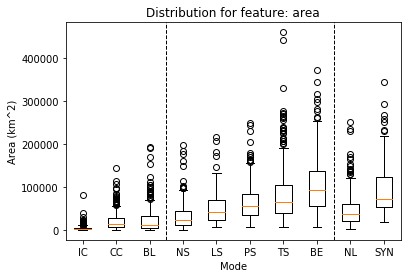

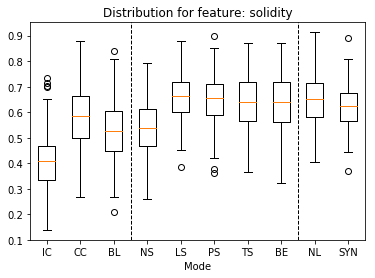

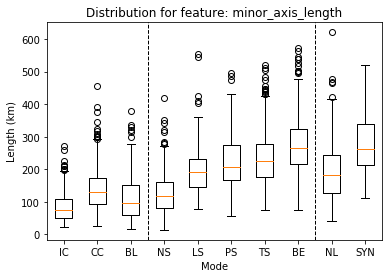

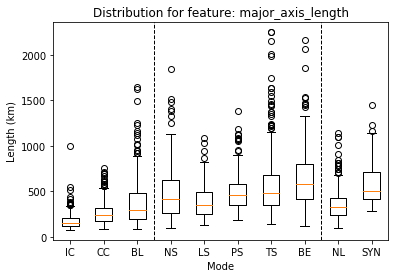

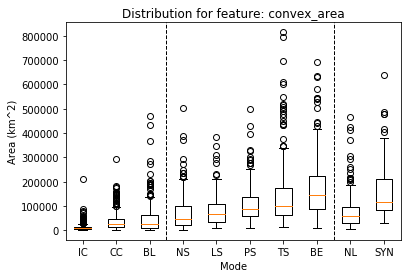

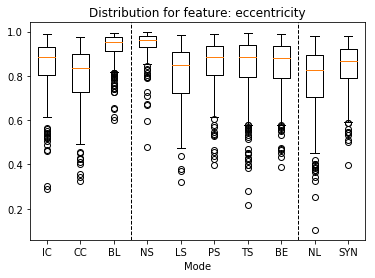

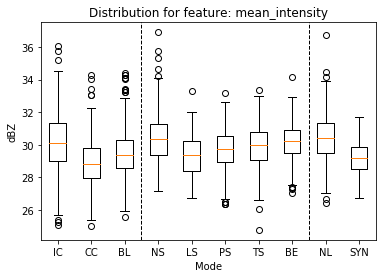

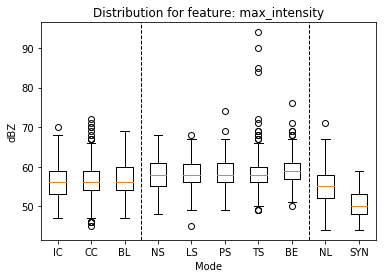

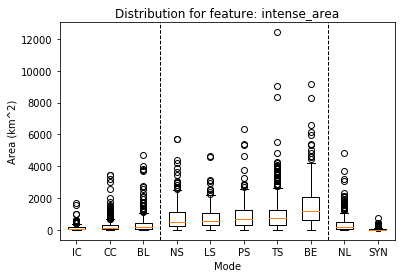

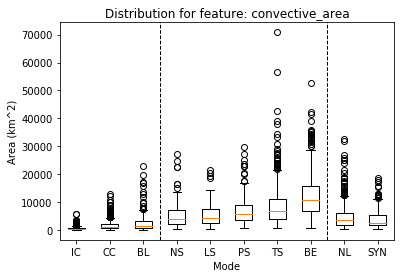

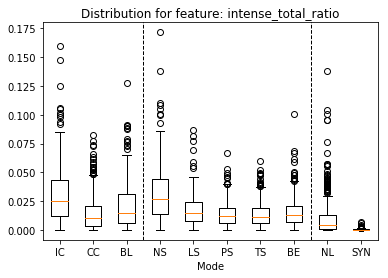

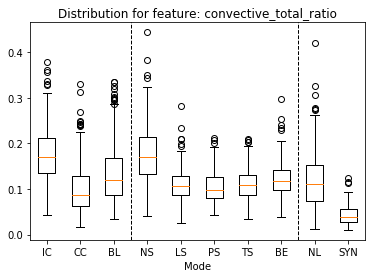

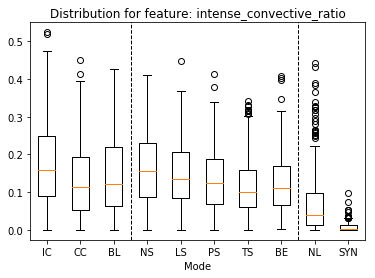

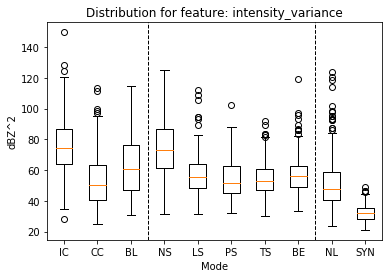

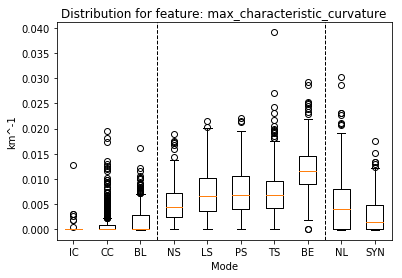

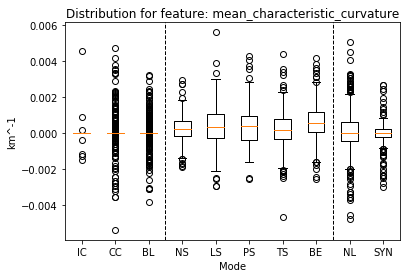

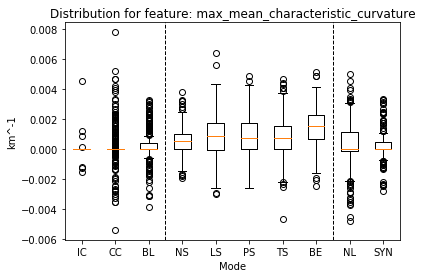

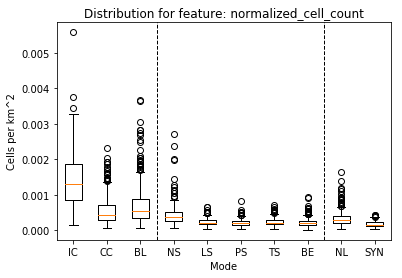

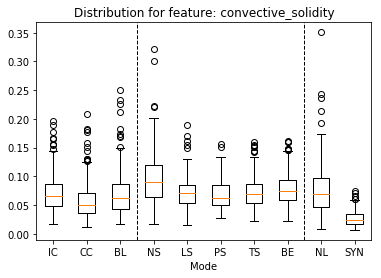

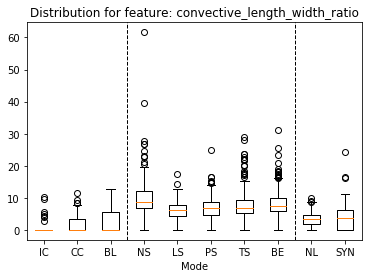

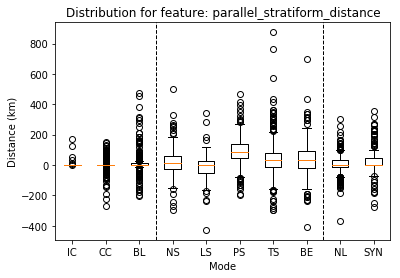

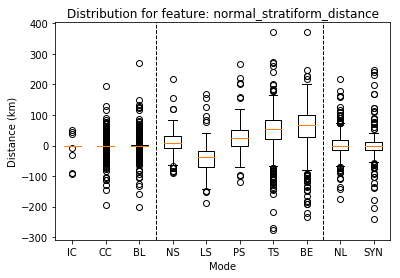

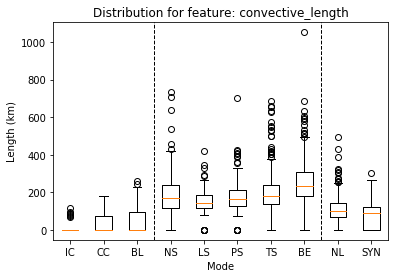

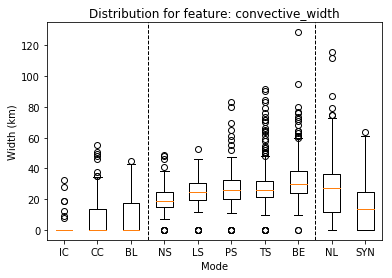

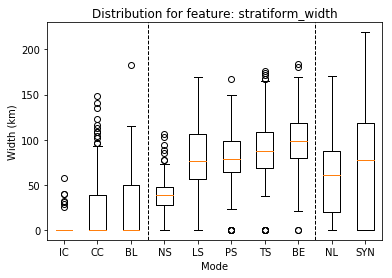

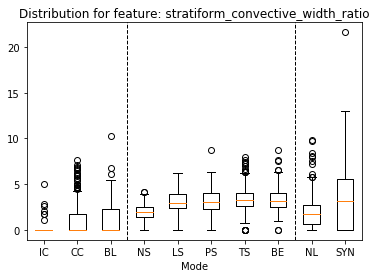

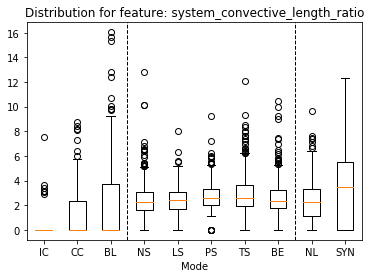

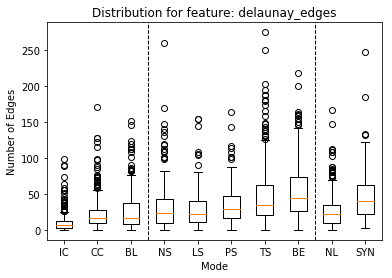

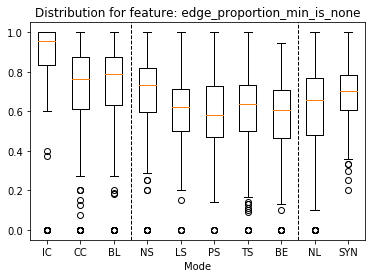

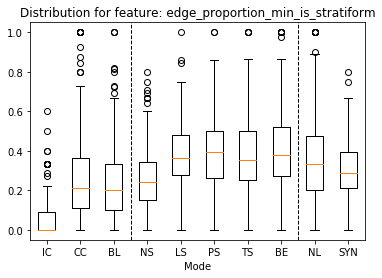

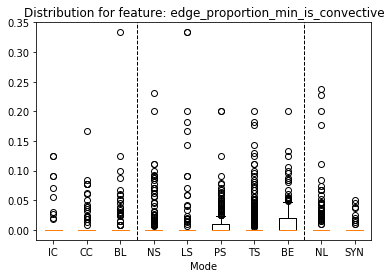

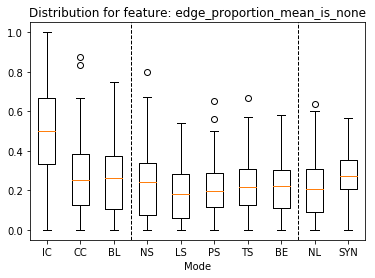

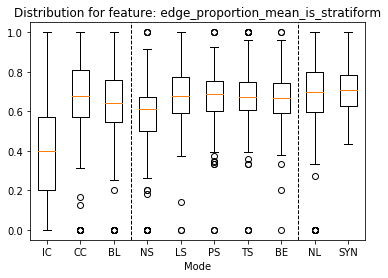

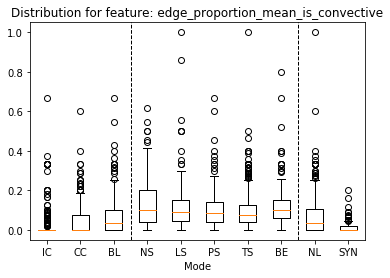

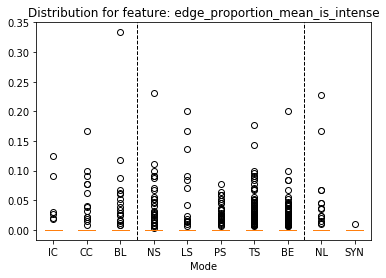

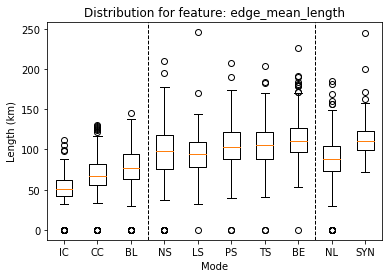

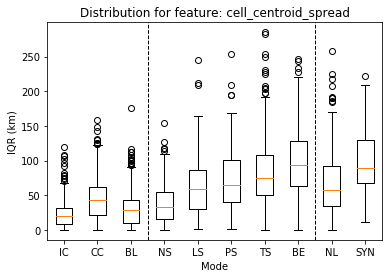

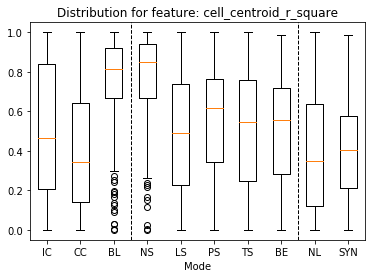

In [21]:
for feature in all_features:
    data = []
    for mode in labels:
        data.append(df[df['mode'] == mode][feature].values)
        
    fig, ax = plt.subplots()
    ax.boxplot(data, labels=labels)
    ax.set_title('Distribution for feature: {}'.format(feature))
    ax.set_xlabel('Mode')
    
    if feature in y_axis_label:
        ax.set_ylabel(y_axis_label[feature])
        
    # Set some dividing lines
    ax.axvline(3.5, color='k', linestyle='--', linewidth=1)
    ax.axvline(8.5, color='k', linestyle='--', linewidth=1)
    
    plt.savefig('feature_dists/barcharts_{}.png'.format(feature), dpi=300, bbox_inches='tight')